In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3, VGG19
import matplotlib.pyplot as plt

1. Загрузите датасет для классификации кошек и собак:

In [2]:
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "D:/python/data/datacatsdogs", # путь к изображениям
    validation_split=0.2, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(200,400), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Using 400 files for validation.


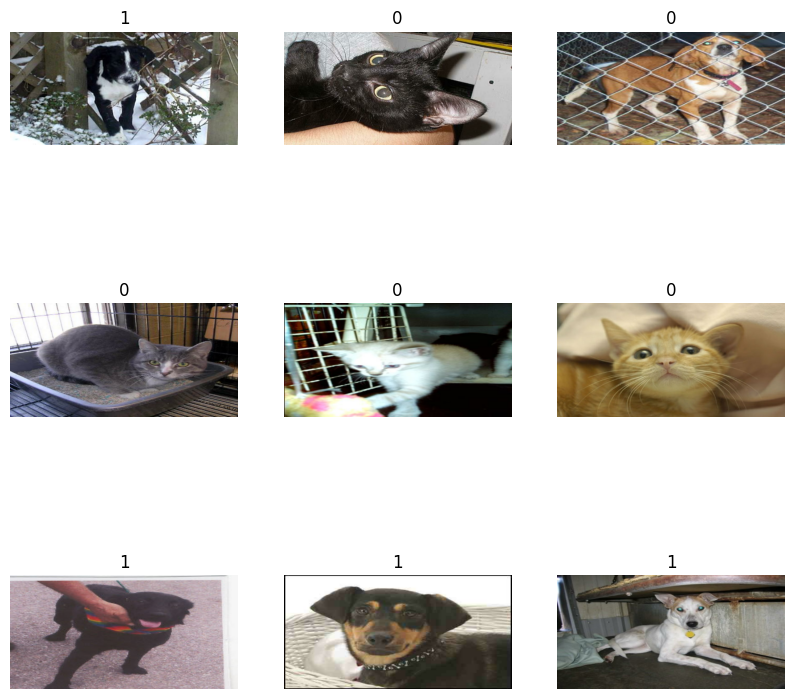

In [3]:
plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

2. Выполните аугментацию.

In [18]:
#генератор дополнительных изображений
image_datagen = ImageDataGenerator(
    rescale=4./255, # Масштабирование значений пикселей в диапазон [0, 1]
    rotation_range=20, # Случайное вращение изображения на угол в диапазоне [-20, 20]
    width_shift_range=0.2, # Случайное горизонтальное смещение (доля от ширины изображения)
    height_shift_range=0.2, # Случайное вертикальное смещение (доля от высоты изображения)
    shear_range=0.2, # Случайное сдвигание (сдвиг угла сдвига в градусах)
    zoom_range=0.2, # Случайное масштабирование изображения
    horizontal_flip=True) # Случайное отражение изображения по горизонтали

In [5]:
model = tf.keras.Sequential([
    # Сверточный слой Conv2D извлекает пространственные признаки изображений с помощью свертки с ядром на входных данных
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(400, 400, 3)), # Это сверточный слой (Convolutional Layer) с 
    #32 фильтрами размером 3x3 и функцией активации ReLU 400 на 400 пикселей и 3 канала
   
    # Слой пулинга MaxPooling2D уменьшает размерность изображений, улавливая наиболее значимую информацию
    tf.keras.layers.MaxPooling2D((2, 2)), # для каждой области 2x2 во входных данных будет выбрано максимальное значение.
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    # плоский слой Flatten преобразует двумерные данные в одномерный вектор
    tf.keras.layers.Flatten(),
    # Полносвязный слой Dense выполняет операции линейной и нелинейной трансформации выходов предыдущего слоя.
    tf.keras.layers.Dense(64, activation='relu'),
    # Выходной слой Dense используется для получения окончательных прогнозов модели. 
    # У нас только один нейрон с функцией активации сигмоида, который представляет вероятности принадлежности к классу "собака" или "кошка".
    tf.keras.layers.Dense(2, activation='softmax')
])

In [6]:
image_generator = image_datagen.flow_from_directory(
    'D:/python/data/datacatsdogs',
    target_size=(400, 400),
    batch_size=32,
    class_mode='categorical')

Found 2000 images belonging to 2 classes.


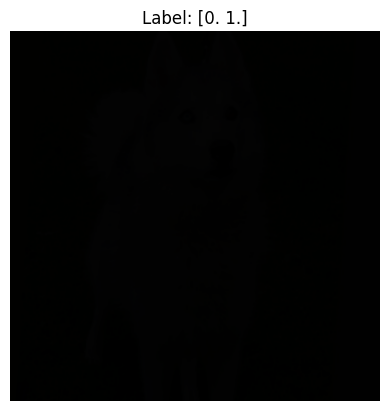

In [48]:
images, labels = next(image_generator)

# Выбираем случайное изображение из батча
random_index = 0  # Индекс случайного изображения в батче (можно изменить)
random_image = images[random_index]
random_label = labels[random_index]

# Отображаем случайное изображение
plt.imshow(random_image.astype("uint8"))
plt.title("Label: {}".format(random_label))
plt.axis("off")
plt.show()

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 398, 398, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 199, 199, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 197, 197, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 98, 98, 64)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 614656)            0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [24]:
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics=["accuracy"])

In [25]:
model.fit(image_generator, epochs=2)

Epoch 1/2
63/63 [==============================] - 122s 2s/step - loss: 2.6724 - accuracy: 0.5285
Epoch 2/2
63/63 [==============================] - 115s 2s/step - loss: 0.6965 - accuracy: 0.5435


In [9]:
img = tf.keras.preprocessing.image.load_img(
    "D:/python/data/photo.jpg", target_size=(400, 400)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)

# Rescale the image
img_array /= 255.0  # Rescale to [0, 1] range

img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
predictions

1/1 [==============================] - 0s 161ms/step


array([[0.5381602, 0.4618398]], dtype=float32)

верно, тк фотография кошки 

## ЗАДАНИЕ №2.

## VGG19

In [13]:
# формируем датасет
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "D:/python/data/101_ObjectCategories", # путь к изображениям
    validation_split=0.15, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(400,400), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

Found 887 files belonging to 3 classes.
Using 754 files for training.
Using 133 files for validation.


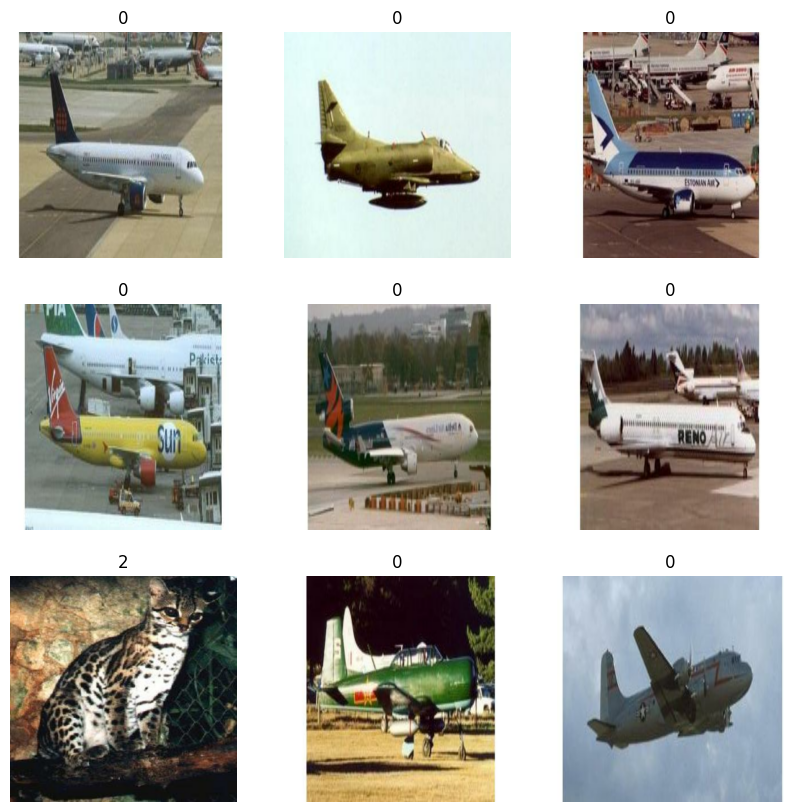

In [16]:
plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")


In [20]:
image_generator = image_datagen.flow_from_directory(
    '../data/101_ObjectCategories',
    target_size=(400,400),
    batch_size=32)

Found 887 images belonging to 3 classes.


In [21]:
# загружаем предварительно обученную сеть VGG19
# weights='imagenet'- уже обучена
# параметр include_top со значением true указывает, что вместе со сверточными будут загружены
# полносвязные слои
vgg = tf.keras.applications.VGG19(weights='imagenet', include_top=False)



80134624/80134624 [==============================] - 75s 1us/step


In [22]:
# "заморозим" все слои
# будут подвержены обучению при обучении модели предпоследний и послединий слои
for layer in vgg.layers:
    layer.trainable = False
vgg.layers[-1].trainable = True
vgg.layers[-3].trainable = True

In [23]:
model_vgg = Sequential() # Создается новая модель типа Sequential. 
model_vgg.add(vgg)
model_vgg.add(GlobalAveragePooling2D())
model_vgg.add(Dense(256, activation='relu'))
model_vgg.add(Dense(3, activation='softmax'))

In [24]:
model_vgg.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [25]:
model_vgg.fit(image_generator, epochs=2)

Epoch 1/2


28/28 [==============================] - 298s 11s/step - loss: 0.2750 - accuracy: 0.8985
Epoch 2/2
28/28 [==============================] - 296s 11s/step - loss: 0.0751 - accuracy: 0.9662


## InceptionV3

In [26]:
inv3 = InceptionV3(weights='imagenet', include_top=False)

87910968/87910968 [==============================] - 81s 1us/step


In [27]:
# "заморозим" все слои, кроме последнего
for layer in inv3.layers:
    layer.trainable = False
inv3.layers[-1].trainable = True
inv3.layers[-3].trainable = True

In [28]:
model_inception = Sequential()
model_inception.add(inv3)
model_inception.add(GlobalAveragePooling2D())
model_inception.add(Dense(256, activation='relu'))
model_inception.add(Dense(3, activation='softmax'))

In [29]:
model_inception.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
model_inception.fit(image_generator, epochs=2)

Epoch 1/2
28/28 [==============================] - 63s 2s/step - loss: 0.3597 - accuracy: 0.9177
Epoch 2/2
28/28 [==============================] - 59s 2s/step - loss: 0.1721 - accuracy: 0.9402
